# Flower classification with resnet

License: public domain.

This is based on the material presented in [Lesson 1: Image classification](https://course.fast.ai/videos/?lesson=1) of the [Practical Deep Learning for Coders, v3](https://course.fast.ai) course by fast.ai.


## Setup

Make sure the code is reloaded automatically and plots are displayed inline.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import the fast.ai libraries.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Looking at the data

Use the [Flower Color Images](https://www.kaggle.com/olgabelitskaya/flower-color-images) dataset published by Olga Belitskaya.

> The content is very simple: 210 images (128x128x3) with 10 species of flowering plants and the file with labels flower-labels.csv. Photo files are in the .png format and the labels are the integers.

In [3]:
LABEL_MAP = {
    0: 'phlox',
    1: 'rose',
    2: 'calendula',
    3: 'iris',
    4: 'leucanthemum maximum',
    5: 'bellflower',
    6: 'viola',
    7: 'rudbeckia laciniata',
    8: 'peony',
    9: 'aquilegia' 
}

# Need to set this to a writable directory.
MODEL_DIR = '/kaggle/working'
DATA_DIR = '../input/flower_images/flower_images'
LABELS = 'flower_labels.csv'
IMAGE_SIZE = 204  # decreasing this negatively affects the results

df = pd.read_csv(f'{DATA_DIR}/{LABELS}')
df.replace(to_replace=LABEL_MAP, inplace=True)
df.head()

,file,label
0,0001.png,phlox
1,0002.png,phlox
2,0003.png,calendula
3,0004.png,phlox
4,0005.png,phlox


In [4]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_df(DATA_DIR, df, ds_tfms=tfms, size=IMAGE_SIZE)
data.classes

['aquilegia',
 'bellflower',
 'calendula',
 'iris',
 'leucanthemum maximum',
 'peony',
 'phlox',
 'rose',
 'rudbeckia laciniata',
 'viola']

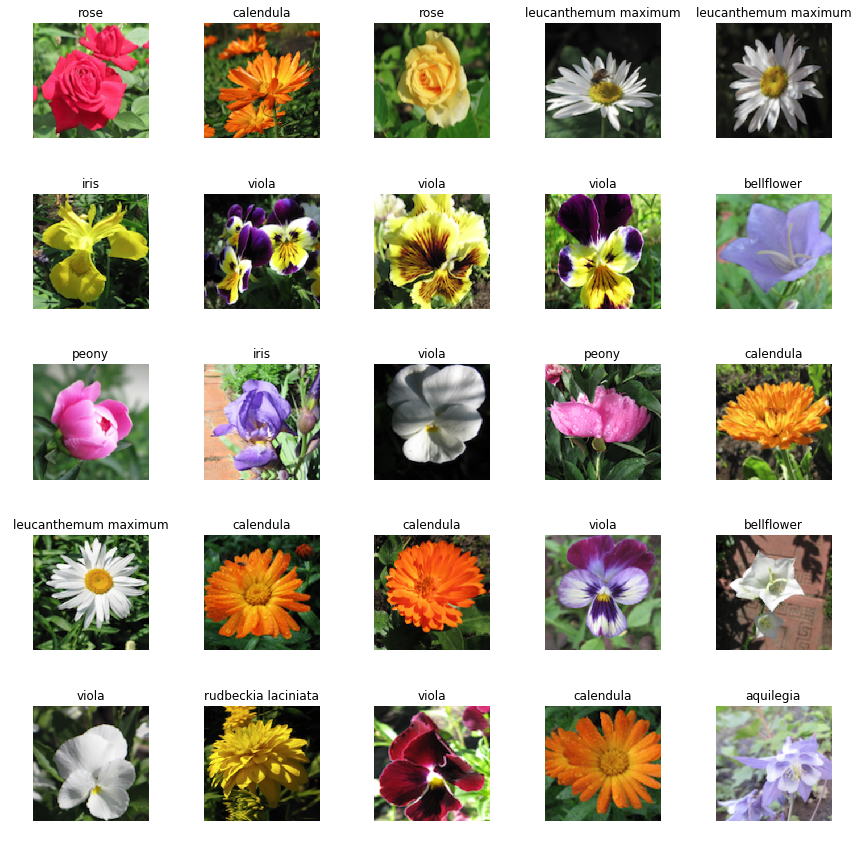

In [5]:
data.show_batch(rows=5, figsize=(12, 12))

In [6]:
len(data.classes), data.c

(10, 10)

## Training: resnet34

We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks), which will be trained for 4 epochs (4 cycles through all the data).

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 45686427.12it/s]


In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.828713,2.562455,0.928571,00:02
1,2.424860,1.895703,0.666667,00:01
2,1.952055,1.479678,0.500000,00:01
3,1.609359,1.311959,0.404762,00:01


In [10]:
learn.model_dir = MODEL_DIR
learn.save('stage-1')

### Results

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

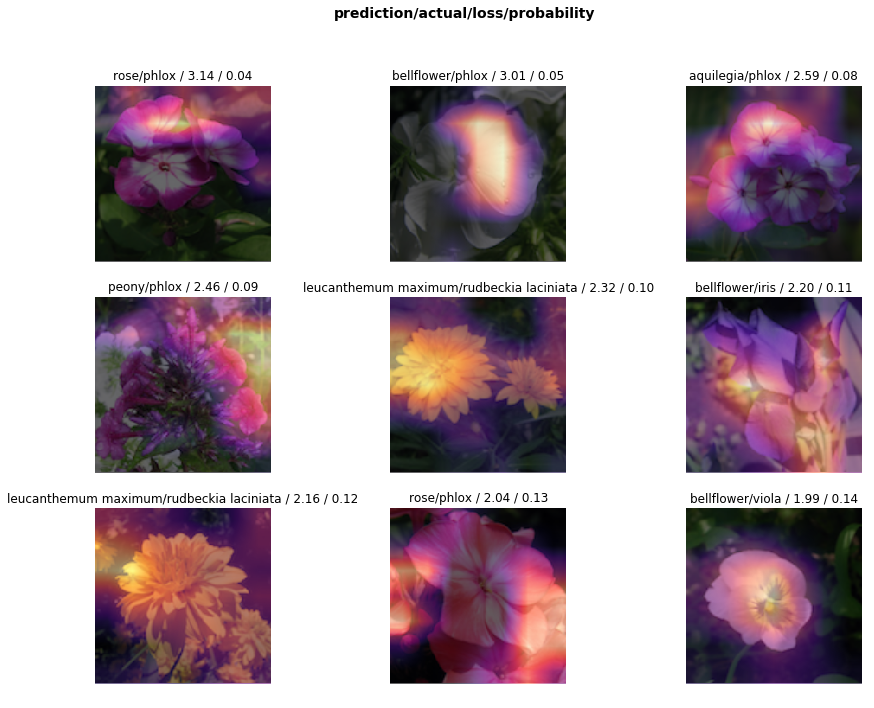

In [12]:
interp.plot_top_losses(9, figsize=(15, 11))

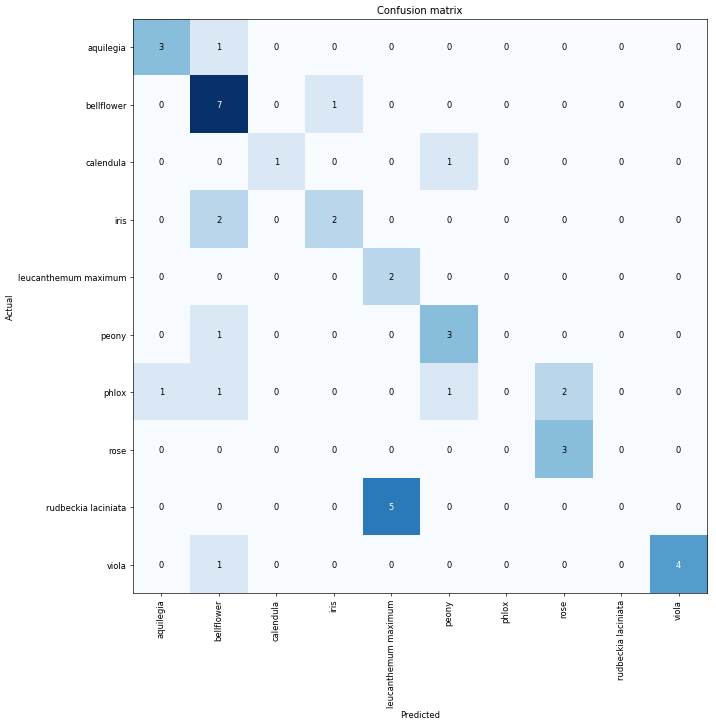

In [13]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

This is not good: lots of mispredictions.

In [14]:
interp.most_confused(min_val=1)

[('rudbeckia laciniata', 'leucanthemum maximum', 5),
 ('iris', 'bellflower', 2),
 ('phlox', 'rose', 2),
 ('aquilegia', 'bellflower', 1),
 ('bellflower', 'iris', 1),
 ('calendula', 'peony', 1),
 ('peony', 'bellflower', 1),
 ('phlox', 'aquilegia', 1),
 ('phlox', 'bellflower', 1),
 ('phlox', 'peony', 1),
 ('viola', 'bellflower', 1)]

### Model tuning

So far, we've been using the model exactly as is.  We've added a few layers to the network and only trained those. It's fast to train and works reasonably well if the network is trained on similar data. See the [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) paper by Matthew D. Zeiler and Rob Fergus to understand why.

So let's allow to train the whole network by calling `unfreeze` and compare the error with the previous result.

In [15]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.594124,1.255012,0.404762,00:01


Now let's revert back to the previous model and look at the learning rate.

In [16]:
learn.load('stage-1');  # ; omits the output

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


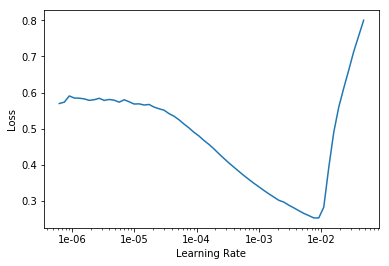

In [18]:
learn.recorder.plot()

Looking at the plot, pick the learning rate range before the loss starts getting worse and train the whole model.

In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.527298,0.975010,0.309524,00:01
1,0.423275,0.692231,0.190476,00:01


Compare the error with the previous result.

Now let's plot the confusion matrix.

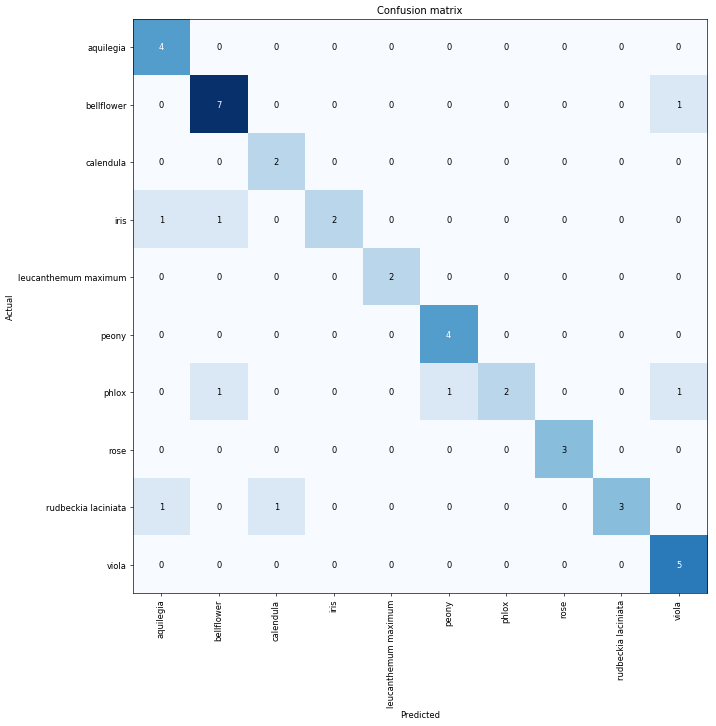

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

The model has improved, but there are still misses.

## Training: resnet50

Let's see if a different network architecture produces better results. See the [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) paper by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun.

In [21]:
data = ImageDataBunch.from_df(DATA_DIR, df, ds_tfms=tfms, size=IMAGE_SIZE, bs=64).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model_dir = MODEL_DIR
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 108809274.55it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


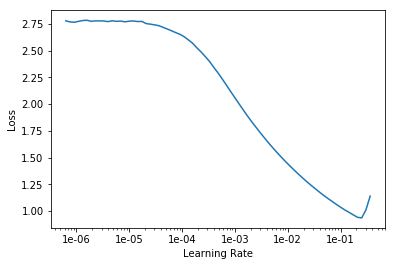

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.737192,2.320988,0.857143,00:02
1,2.079988,1.611410,0.523810,00:01
2,1.490231,0.973884,0.261905,00:01
3,1.138885,0.674223,0.214286,00:01
4,0.919154,0.548721,0.190476,00:01
5,0.759582,0.459205,0.166667,00:01
6,0.643227,0.412776,0.142857,00:01
7,0.558867,0.392187,0.119048,00:01


In [24]:
learn.save('stage-1-50')

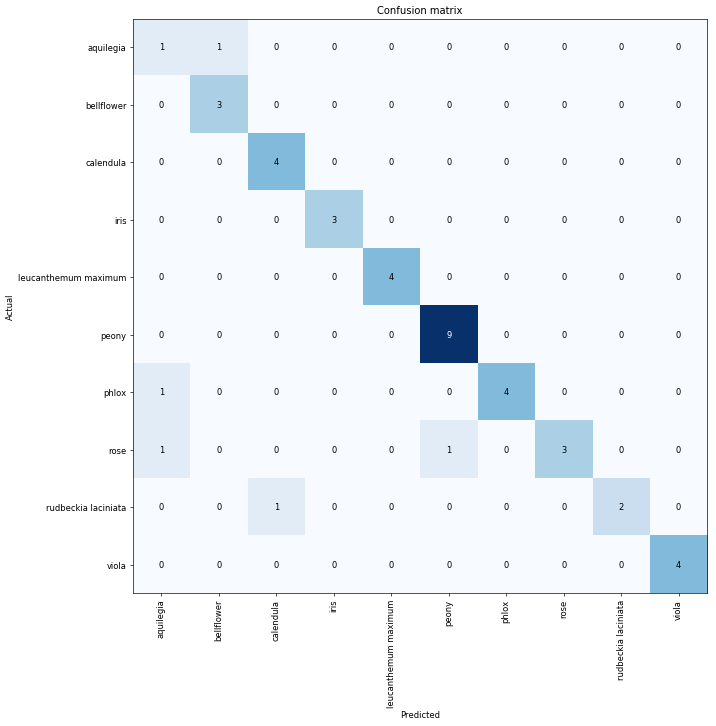

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

Much better results this time.

In [26]:
interp.most_confused(min_val=1)

[('aquilegia', 'bellflower', 1),
 ('phlox', 'aquilegia', 1),
 ('rose', 'aquilegia', 1),
 ('rose', 'peony', 1),
 ('rudbeckia laciniata', 'calendula', 1)]

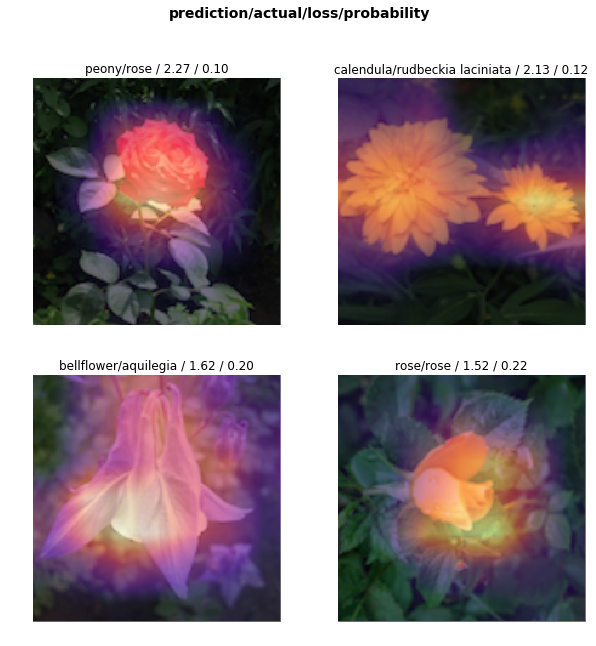

In [27]:
interp.plot_top_losses(4, figsize=(10, 10))

Let's see if it's possible to improve the model even further based on the plotted learning rate.

In [28]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.049029,0.518820,0.119048,00:02
1,0.046631,0.645184,0.119048,00:01
2,0.040015,0.681980,0.119048,00:01


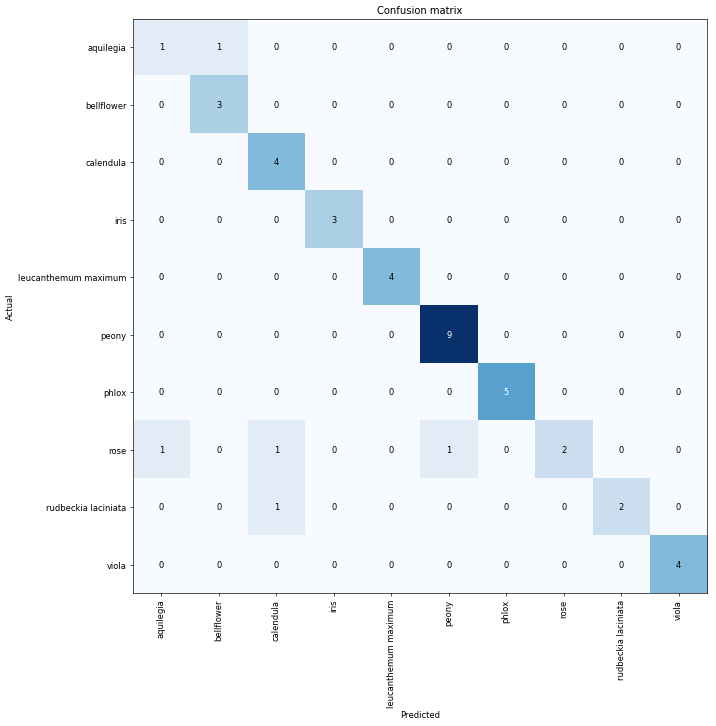

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [30]:
interp.most_confused(min_val=1)

[('aquilegia', 'bellflower', 1),
 ('rose', 'aquilegia', 1),
 ('rose', 'calendula', 1),
 ('rose', 'peony', 1),
 ('rudbeckia laciniata', 'calendula', 1)]